# Visualize the linear model coefficients as scatter plots


## Import libraries


In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Set paths and load in TSV


In [2]:
# path to tsv with LM coefficients
lm_results_dir <- file.path("./results")
lm_file <- file.path(lm_results_dir, "./linear_model_cp_features_plate5_WT_HET.tsv")

# save path for figure
lm_fig_dir <- file.path("./figures")
lm_fig <- file.path(lm_fig_dir, "linear_model_cp_features_plate5_WT_HET.png")

# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file,
    col_types = readr::cols(.default = "d", feature = "c")
)

print(dim(lm_df))
head(lm_df)


[1] 2287    5


feature,r2_score,cell_count_coef,HET_coef,WT_coef
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_AreaShape_Area,0.0098530198,-0.0035487792,0.052613112,-0.052613112
Cytoplasm_AreaShape_BoundingBoxArea,0.0141127217,-0.0017103140,0.110601453,-0.110601453
Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.0003896894,0.0008371267,0.022413689,-0.022413689
Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.0048622573,-0.0019227302,0.043768084,-0.043768084
Cytoplasm_AreaShape_BoundingBoxMinimum_X,0.0006961657,0.0010687361,-0.009882193,0.009882193
Cytoplasm_AreaShape_BoundingBoxMinimum_Y,0.0014971705,-0.0010221039,0.024953340,-0.024953340


## Clean up the data frame for visualization


In [3]:
# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(WT_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel",
            "parameter1",
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

# Clean channel for visualization and interpretation
lm_df$channel_cleaned <-
    dplyr::recode(
        lm_df$channel_cleaned,
        "DAPI" = "nuclei",
        "GFP" = "ER",
        "RFP" = "actin",
        "CY5" = 'mito',
        .default = "other",
        .missing = "other"
    )

# Print to make sure that the above clean up worked
print(dim(lm_df))
head(lm_df, 10)


Warning message:
“Expected 6 pieces. Additional pieces discarded in 624 rows [17, 26, 27, 29, 32,
39, 41, 43, 45, 48, 50, 52, 53, 55, 60, 61, 62, 63, 64, 65, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 943 rows [1, 2, 3, 4, 5,
7, 8, 9, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, ...].”


[1] 2287   12


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score,cell_count_coef,HET_coef,WT_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cytoplasm_Correlation_K_GFP_CY5,Cytoplasm,Correlation,K,GFP,CY5,NA,0.09510576,3.705398e-03,0.3415120,-0.3415120,ER
Cytoplasm_Correlation_K_CY5_GFP,Cytoplasm,Correlation,K,CY5,GFP,NA,0.10090833,-6.110465e-03,-0.3386760,0.3386760,mito
Cells_Correlation_K_GFP_CY5,Cells,Correlation,K,GFP,CY5,NA,0.09113894,3.316926e-03,0.3308395,-0.3308395,ER
Cells_Correlation_K_CY5_GFP,Cells,Correlation,K,CY5,GFP,NA,0.09233341,-5.583541e-03,-0.3230418,0.3230418,mito
Cells_Correlation_Correlation_DAPI_GFP,Cells,Correlation,Correlation,DAPI,GFP,NA,0.06638225,-1.225798e-03,0.2538474,-0.2538474,nuclei
Nuclei_RadialDistribution_ZernikeMagnitude_DAPI_2_2,Nuclei,RadialDistribution,ZernikeMagnitude,DAPI,2,2,0.04211572,1.725782e-03,0.2268235,-0.2268235,nuclei
Cells_Correlation_K_CY5_RFP,Cells,Correlation,K,CY5,RFP,NA,0.05403512,3.984814e-04,-0.2261136,0.2261136,mito
Cytoplasm_Intensity_IntegratedIntensityEdge_DAPI,Cytoplasm,Intensity,IntegratedIntensityEdge,DAPI,NA,NA,0.04258942,4.517449e-03,0.2259857,-0.2259857,nuclei
Cytoplasm_Correlation_K_CY5_RFP,Cytoplasm,Correlation,K,CY5,RFP,NA,0.05250448,-5.957911e-05,-0.2256443,0.2256443,mito


## Visualize LM as scatter plot


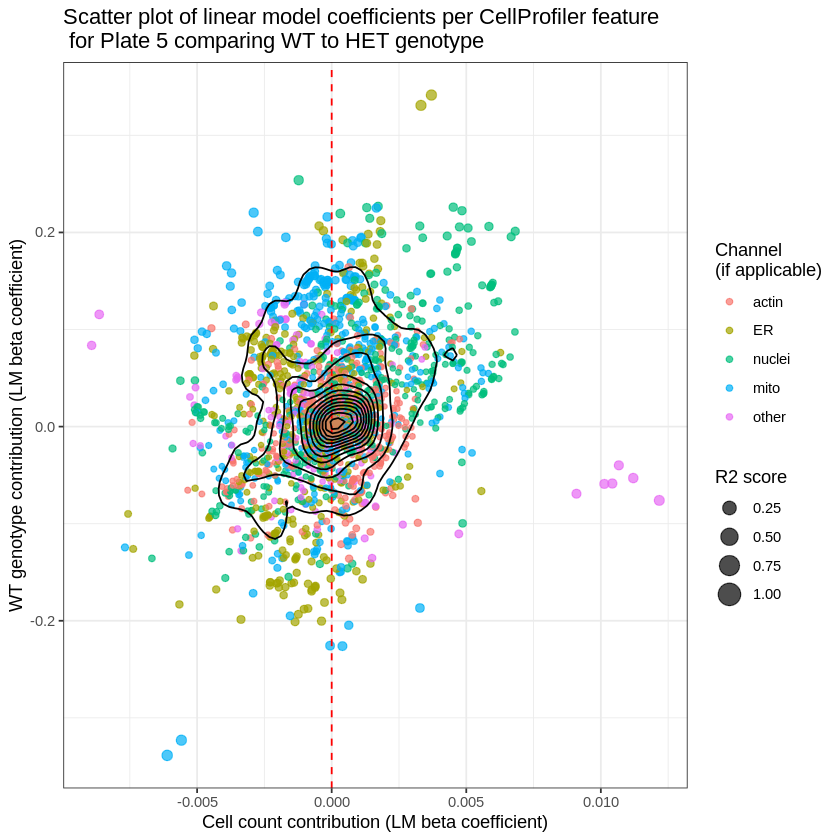

In [4]:
# Specify order so that the organelles match the correct color (red, green, blue)
color_order <- c("actin", "ER", "nuclei", "mito", "other")

# Plot the linear model coefficients for the WT genotype contribution
# Positive coeff = more likely to be WT cell if feature increases
# Negative coeff = more likely to be Null cell if feature increases
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = HET_coef))
    +
        geom_point(aes(size = r2_score, color = factor(channel_cleaned, levels = color_order)), alpha = 0.7)
        +
        geom_vline(xintercept = 0, linetype = "dashed", color = "red")
        +
        geom_density2d(color = "black", show.legend = FALSE)
        +
        theme_bw()
        +
        guides(
            color = guide_legend(title = "Channel\n(if applicable)", order = 1),
            size = guide_legend(title = "R2 score")
        )
        +
        ylab("WT genotype contribution (LM beta coefficient)")
        +
        xlab("Cell count contribution (LM beta coefficient)")
        +
        ggtitle("Scatter plot of linear model coefficients per CellProfiler feature\n for Plate 5 comparing WT to HET genotype") # nolint
)

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

# Show figure
lm_fig_gg
